# Requirements

# Imports

In [57]:
from datasets import load_dataset
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Chargement des données et pré-traitement

In [58]:
df = pd.read_csv('notsoclean.csv')
numeric_df = df.select_dtypes(include=[np.number])

In [59]:
numeric_df.columns

Index(['age', 'membership_category', 'joined_through_referral',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount',
       'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score'],
      dtype='object')

In [60]:
df.columns

Index(['age', 'gender', 'security_no', 'region_category',
       'membership_category', 'joining_date', 'joined_through_referral',
       'referral_id', 'preferred_offer_types', 'medium_of_operation',
       'internet_option', 'last_visit_time', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score'],
      dtype='object')

In [61]:
scaler = MinMaxScaler()
for column in numeric_df.columns:
    x = numeric_df[[column]].values
    x_scaled = scaler.fit_transform(x)
    numeric_df[column] = x_scaled

numeric_df.head()

,age,membership_category,joined_through_referral,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,past_complaint,complaint_status,feedback,churn_risk_score
0,0.148148,0.8,0.0,0.64,0.098333,0.526717,0.547827,0.375887,1.0,0.0,0.25,0.0,0.0
1,0.629630,0.0,1.0,0.52,0.169265,0.204074,0.592988,0.239624,0.0,1.0,0.75,1.0,1.0
2,0.500000,0.0,1.0,0.40,0.016927,0.246577,0.448473,0.272092,0.0,1.0,1.00,1.0,1.0
3,0.388889,0.0,0.0,0.76,0.036627,0.238950,0.538795,0.318344,0.0,1.0,0.50,1.0,1.0
4,0.055556,0.6,0.0,0.88,0.142100,0.132013,0.611052,0.347050,1.0,1.0,1.00,0.5,0.0


In [68]:
num_corr = numeric_df.corr()
num_corr['churn_risk_score']
sorted_correlated = num_corr.map(lambda x: abs(x)).sort_values('churn_risk_score', ascending=False)['churn_risk_score'][:10]
sorted_correlated


churn_risk_score            1.000000
membership_category         0.748550
feedback                    0.397336
points_in_wallet            0.316213
avg_transaction_value       0.214946
avg_frequency_login_days    0.134382
joined_through_referral     0.032053
days_since_last_login       0.020117
used_special_discount       0.018048
avg_time_spent              0.014029
Name: churn_risk_score, dtype: float64

# Matrice de Corrélation

Essayons d'abord de comprendre comment sont corrélés nos attributs d'entrée dans notre dataset.
On note pas de grande redondance entre nos informations, éventuellement au niveau de l'attribut "has completed preparation test"

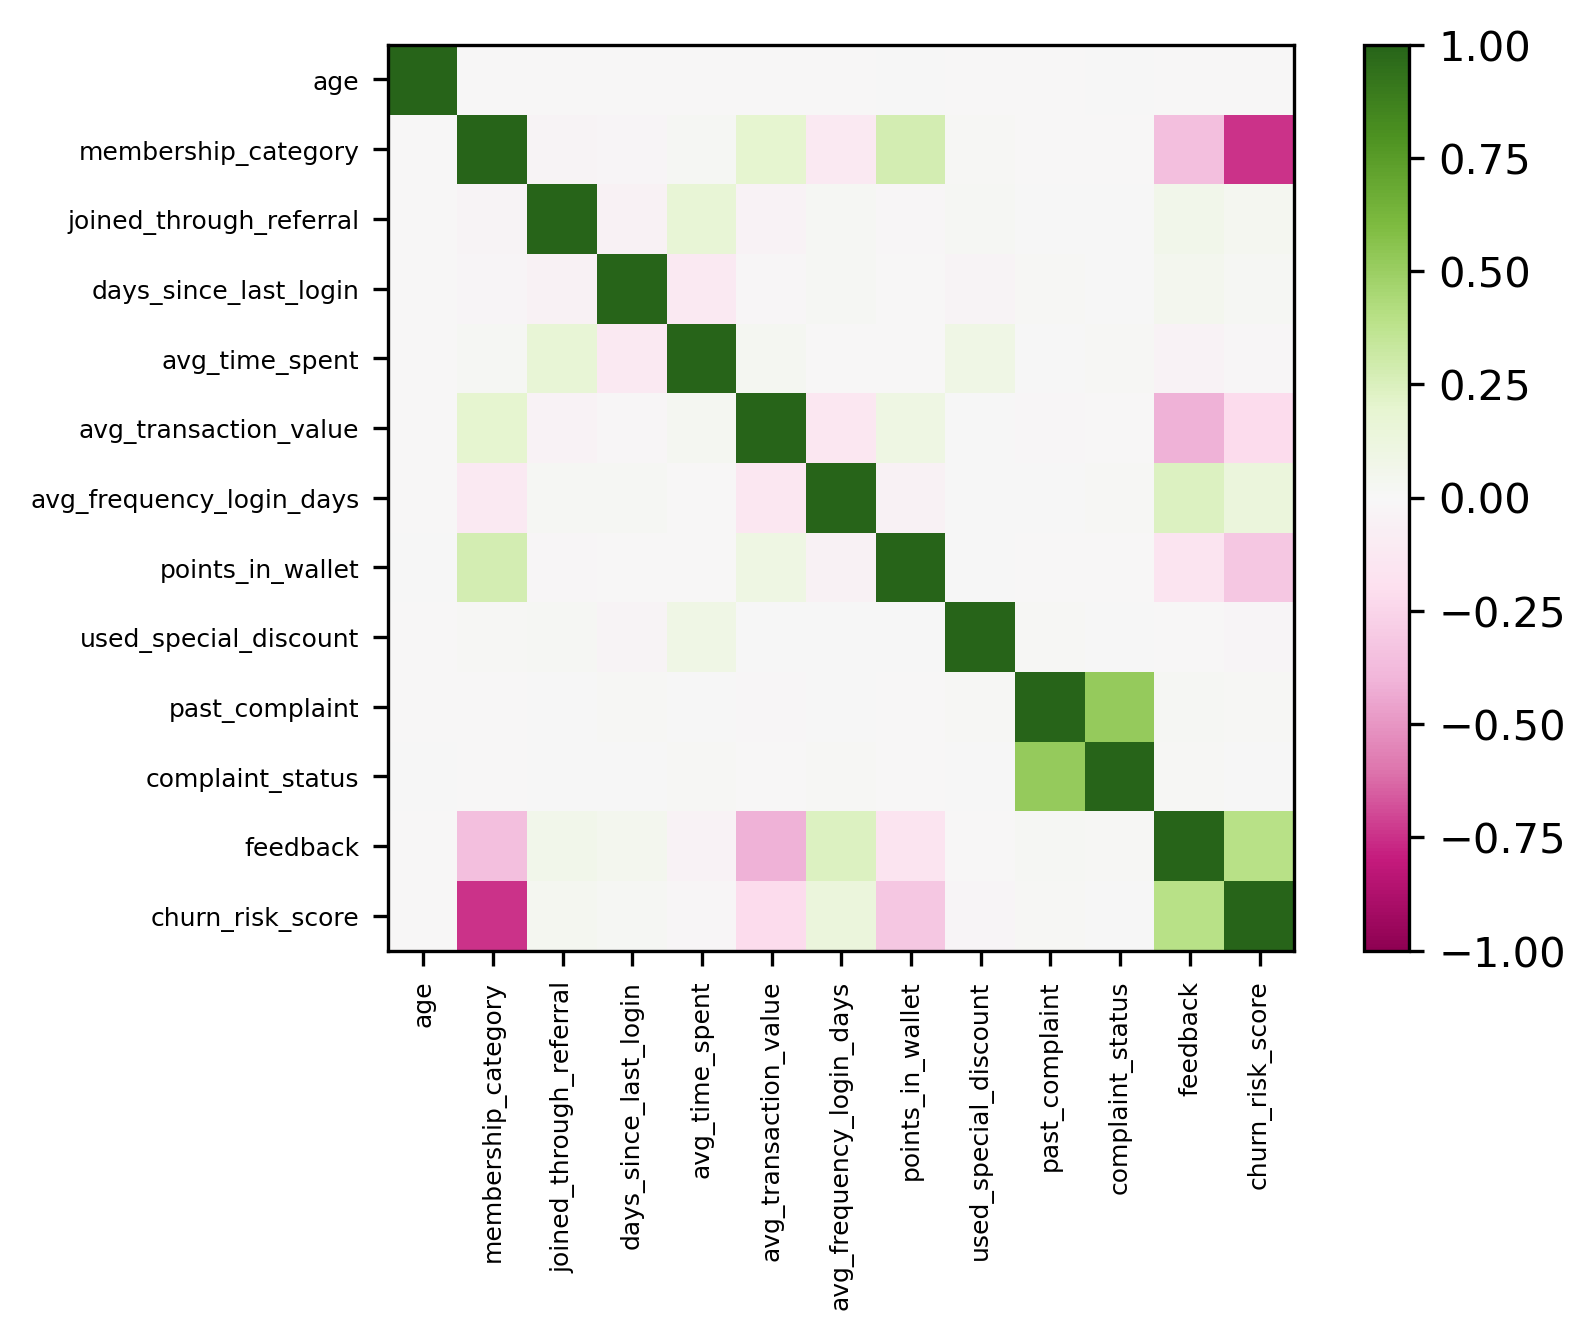

In [63]:
plt.figure(dpi=300)
plt.imshow(num_corr, cmap=plt.get_cmap("PiYG"), vmin=-1, vmax=1) # Pour se convaincre qu'il y a bien de la corrélation
plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, fontsize=6, rotation=90)
plt.yticks(range(len(numeric_df.columns)), numeric_df.columns, fontsize=6)
plt.colorbar()

In [64]:
from typing import Any
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

class GenericModel():
    def __init__(self, X_train, y_train, X_test, y_test, kernel: str = 'logistic_regression'):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        if kernel == 'logistic_regression':
            self.model = LogisticRegression()
        elif kernel == 'random_forest':
            self.model = RandomForestClassifier()
        elif kernel == 'svm':
            self.model = SVC()
        elif kernel == 'knn':
            self.model = KNeighborsClassifier()
        elif kernel == 'decision_tree':
            self.model = DecisionTreeClassifier()
        else:
            raise ValueError("Invalid kernel")

    def training_score(self, verbose: bool = True) -> Any:
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)

        accuracy = accuracy_score(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred)

        if verbose:
            print(f"Accuracy: {accuracy}")
            print("Classification Report:")
            print(report)
        return accuracy, report

In [65]:
def benchmark_model(df, y_col: str ='churn_risk_score') -> Any:
    X_train, X_test, y_train, y_test = train_test_split(df.drop(y_col, axis=1), df[y_col], test_size=0.2, random_state=42)
    logistic_reg = GenericModel(X_train, y_train, X_test, y_test, kernel='logistic_regression')
    random_forest = GenericModel(X_train, y_train, X_test, y_test, kernel='random_forest')
    svm = GenericModel(X_train, y_train, X_test, y_test, kernel='svm')
    knn = GenericModel(X_train, y_train, X_test, y_test, kernel='knn')
    decision_tree = GenericModel(X_train, y_train, X_test, y_test, kernel='decision_tree')
    
    # Training and scoring
    print("------Logistic Regression------")
    logistic_reg.training_score(verbose=True)
    print("------Random Forest------")
    random_forest.training_score(verbose=True)
    print("------SVM------")
    svm.training_score(verbose=True)
    print("------KNN------")
    knn.training_score(verbose=True)
    print("------Decision Tree------")
    decision_tree.training_score(verbose=True)

In [66]:
numeric_df_without_na = numeric_df.dropna(inplace=False)
features = numeric_df_without_na.drop('churn_risk_score', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, numeric_df_without_na.churn_risk_score, test_size=0.2, random_state=42)

benchmark_model(numeric_df_without_na)

------Logistic Regression------
Accuracy: 0.8587704213241617
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      2178
         1.0       0.87      0.87      0.87      2474

    accuracy                           0.86      4652
   macro avg       0.86      0.86      0.86      4652
weighted avg       0.86      0.86      0.86      4652

------Random Forest------
Accuracy: 0.9445399828030955
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      2178
         1.0       0.94      0.95      0.95      2474

    accuracy                           0.94      4652
   macro avg       0.94      0.94      0.94      4652
weighted avg       0.94      0.94      0.94      4652

------SVM------
Accuracy: 0.8529664660361135
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      2178
       

In [67]:
reduced_df = df[['churn_risk_score', "membership_category", "feedback", "points_in_wallet", "avg_transaction_value", "avg_frequency_login_days", "joined_through_referral", "days_since_last_login"]]

reduced_df = reduced_df.dropna(inplace=False)
features = reduced_df.drop('churn_risk_score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, reduced_df.churn_risk_score, test_size=0.2, random_state=42)
benchmark_model(reduced_df)


------Logistic Regression------


/home/xennos/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8428632846087705
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2178
           1       0.86      0.84      0.85      2474

    accuracy                           0.84      4652
   macro avg       0.84      0.84      0.84      4652
weighted avg       0.84      0.84      0.84      4652

------Random Forest------
Accuracy: 0.943250214961307
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2178
           1       0.94      0.96      0.95      2474

    accuracy                           0.94      4652
   macro avg       0.94      0.94      0.94      4652
weighted avg       0.94      0.94      0.94      4652

------SVM------
Accuracy: 0.6137145313843508
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.30      2178
           1       0.58      1.00      0